In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float64)

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
from Utils.bernstein_torch import bernstein_coeff_order10_new

# Generating P matrix
t_fin = 15.0
num = 100
tot_time = torch.linspace(0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

In [4]:
# Custom Dataset Loader 
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, data):
        
        # Inputs
        self.inp = data[:, 0:55]
        
        # Outputs
        self.out = data[:, 55:]
        
    def __len__(self):
        return len(self.inp)
    
    def __getitem__(self, idx):
        
        # Inputs
        inp = self.inp[idx]
        
        # Outputs
        out = self.out[idx]
                 
        return torch.tensor(inp).double(), torch.tensor(out).double()

# Load the dataset
train_data = np.load("./Preprocessed Data/train_lane_4.npy", mmap_mode="c")

# Using PyTorch Dataloader
train_dataset = TrajDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=2145, shuffle=True, num_workers=0)

torch.Size([2145, 55]) torch.Size([2145, 22])


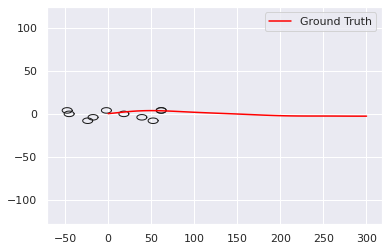

In [5]:
# Sanity Check
for batch_num, (datas) in enumerate(train_loader):
    inp, out = datas
    
    print(inp.shape, out.shape)
        
    num = 2
    
    # Sanity Check
    x_obs = inp[num].flatten()[5::5]
    y_obs = inp[num].flatten()[6::5]
     
    th = np.linspace(0, 2 * np.pi, 100)
    plt.figure(1)
    
    a_obs, b_obs = 5.8, 3.2
    
    for i in range(0, 10):
        x_ell = x_obs[i] + a_obs * np.cos(th)
        y_ell = y_obs[i] + b_obs * np.sin(th)
        plt.plot(x_ell, y_ell, '-k', linewidth=1.0)

    plt.axis('equal')
        
    cx = out[num].flatten()[0:11]
    cy = out[num].flatten()[11:22]
    
    x_gt = P.cpu() @ cx
    y_gt = P.cpu() @ cy
    
    plt.plot(x_gt.numpy(), y_gt.numpy(), label="Ground Truth", color="red")
    plt.legend()
    plt.show()
    
    break

In [6]:
from Utils.beta_cvae_aug_ddn import Encoder, Decoder, Beta_cVAE, BatchOpt_DDN, DeclarativeLayer

# DDN
num_batch = train_loader.batch_size
node = BatchOpt_DDN(P, Pdot, Pddot, num_batch)
opt_layer = DeclarativeLayer(node)

# Beta-cVAE Inputs
enc_inp_dim = 55
enc_out_dim = 200
dec_inp_dim = enc_inp_dim
dec_out_dim = 8
hidden_dim = 1024 * 2
z_dim = 2

inp_mean, inp_std = 5.1077423, 20.914295

encoder = Encoder(enc_inp_dim, enc_out_dim, hidden_dim, z_dim)
decoder = Decoder(dec_inp_dim, dec_out_dim, hidden_dim, z_dim)
model = Beta_cVAE(encoder, decoder, opt_layer, inp_mean, inp_std).to(device)

In [7]:
P = torch.block_diag(P, P).to(device)
Pdot = Pdot.to(device)
Pddot = Pddot.to(device)

In [9]:
epochs = 60
step, beta = 0, 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay=6e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 12, gamma = 0.1)

avg_train_loss, avg_rcl_loss, avg_kl_loss, avg_aug_loss = [], [], [], []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, kl_losses, rcl_losses, aug_losses = [], [], [], []
    model.train()
    for inp, out in train_loader:
        
        inp = inp.to(device)
        out = out.to(device)
        traj_gt = (P @ out.T).T
       
        # Ego vehicle states
        initial_state_ego = inp[:, 2:6]
        initial_state_ego[:, 2:4] = initial_state_ego[:, 0:2]
        initial_state_ego[:, 0:2] = 0
               
        # Remember to add the Aug Loss
        KL_loss, RCL_loss, loss, _ = model.forward(inp, traj_gt, initial_state_ego, P, Pdot, Pddot, beta, step)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        rcl_losses.append(RCL_loss.detach().cpu().numpy())
        kl_losses.append(KL_loss.detach().cpu().numpy())
        # aug_losses.append(Aug.detach().cpu().numpy())

    if epoch % 1 == 0:    
        print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f}, RCL: {np.average(rcl_losses):.3f}, KL: {np.average(kl_losses):.3f}") #, Aug: {np.average(aug_losses):.3f}")

    step += 1.0
    scheduler.step()
    avg_train_loss.append(np.average(losses_train)), avg_rcl_loss.append(np.average(rcl_losses)), \
    avg_kl_loss.append(np.average(kl_losses)) #, avg_aug_loss.append(np.average(aug_losses))

Epoch: 1, Train Loss: 9.481, RCL: 9.481, KL: 14.735
Epoch: 2, Train Loss: 2.839, RCL: 2.788, KL: 14.381
Epoch: 3, Train Loss: 2.342, RCL: 2.259, KL: 11.858
Epoch: 4, Train Loss: 2.254, RCL: 2.151, KL: 9.807
Epoch: 5, Train Loss: 2.254, RCL: 2.134, KL: 8.564
Epoch: 6, Train Loss: 2.212, RCL: 2.072, KL: 8.003
Epoch: 7, Train Loss: 2.142, RCL: 1.983, KL: 7.589
Epoch: 8, Train Loss: 1.933, RCL: 1.756, KL: 7.211
Epoch: 9, Train Loss: 2.186, RCL: 1.990, KL: 7.031
Epoch: 10, Train Loss: 1.964, RCL: 1.751, KL: 6.776
Epoch: 11, Train Loss: 1.952, RCL: 1.722, KL: 6.557
Epoch: 12, Train Loss: 2.143, RCL: 1.896, KL: 6.425
Epoch: 13, Train Loss: 1.541, RCL: 1.280, KL: 6.225
Epoch: 14, Train Loss: 1.552, RCL: 1.276, KL: 6.074
Epoch: 15, Train Loss: 1.518, RCL: 1.226, KL: 5.949
Epoch: 16, Train Loss: 1.532, RCL: 1.226, KL: 5.824
Epoch: 17, Train Loss: 1.550, RCL: 1.229, KL: 5.721
Epoch: 18, Train Loss: 1.552, RCL: 1.218, KL: 5.624
Epoch: 19, Train Loss: 1.558, RCL: 1.210, KL: 5.527
Epoch: 20, Train L

In [10]:
torch.save(model.state_dict(), './Weights/cvae_aug_mse.pth')